## Read Cython OpenBCI .xdf data

In [17]:
# Some standard pythonic imports
import warnings
warnings.filterwarnings('ignore')
import os,numpy as np,pandas as pd
from collections import OrderedDict
import seaborn as sns
from matplotlib import pyplot as plt

# MNE functions
import mne
from mne import Epochs,find_events
from mne.decoding import Vectorizer

# Scikit-learn and Pyriemann ML functionalities
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from pyriemann.estimation import ERPCovariances, XdawnCovariances, Xdawn
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

import pyxdf
import PyQt5


import pathlib

# For interactive plots
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'qt')


## Set data path and read data

In [18]:
current_path = pathlib.Path().absolute()  
data_fname = current_path /'GiladP300_27.11.xdf'
print(data_fname)
streams, header = pyxdf.load_xdf(data_fname)

C:\Users\gilad\GiladP300_27.11.xdf


## before we are able to create a MNE raw instance, we need to create "info" object and prepare the data
(https://mne.tools/stable/auto_tutorials/simulation/10_array_objs.html#sphx-glr-auto-tutorials-simulation-10-array-objs-py)

Look for data[0:13] and data[13:], the first 13 rows should contain the actual electrode while the last 3 contains the Na channels

In [19]:
stream_count = 0

for stream in streams:
    if stream['info']['channel_count'] == ['16']:
        eeg_stream = stream
        #data_eeg = stream["time_series"].T
        stream_count += 1
    elif stream['info']['channel_count'] == ['1']:
        marker_stream = stream
        stream_count += 1
    else:
        print('Not recognized channel')

    
print (f'{stream_count} streams loaded') 

# Prepare the time series data

eeg_data = eeg_stream["time_series"].T

2 streams loaded


In [20]:
# Create Raw without sim channel

ch_types = ['eeg'] * 13 
ch_names = ['C3','C4','Cz','FC1','FC2','FC5','FC6','CP1','CP2','CP5','CP6','O1','O2']



#data_marker = streams[0]
 
eeg_data = eeg_data[0:13]
#data[:4:2] -= data[1:4:2]  # subtract (rereference) to get two bipolar EEG
#data = data[::2]  # subselect
#data *= 1000
eeg_data *= (1e-6 / 50 / 2)  # Not sure if that is the correct way (uV -> V and preamp gain)
sfreq = float(eeg_stream["info"]["nominal_srate"][0])
info = mne.create_info(ch_names= ch_names, ch_types=ch_types, sfreq=sfreq)
info.set_montage('standard_1020')

<Info | 8 non-empty values
 bads: []
 ch_names: C3, C4, Cz, FC1, FC2, FC5, FC6, CP1, CP2, CP5, CP6, O1, O2
 chs: 13 EEG
 custom_ref_applied: False
 dig: 16 items (3 Cardinal, 13 EEG)
 highpass: 0.0 Hz
 lowpass: 62.5 Hz
 meas_date: unspecified
 nchan: 13
 projs: []
 sfreq: 125.0 Hz
>

Creating RawArray with float64 data, n_channels=13, n_times=31405
    Range : 0 ... 31404 =      0.000 ...   251.232 secs
Ready.


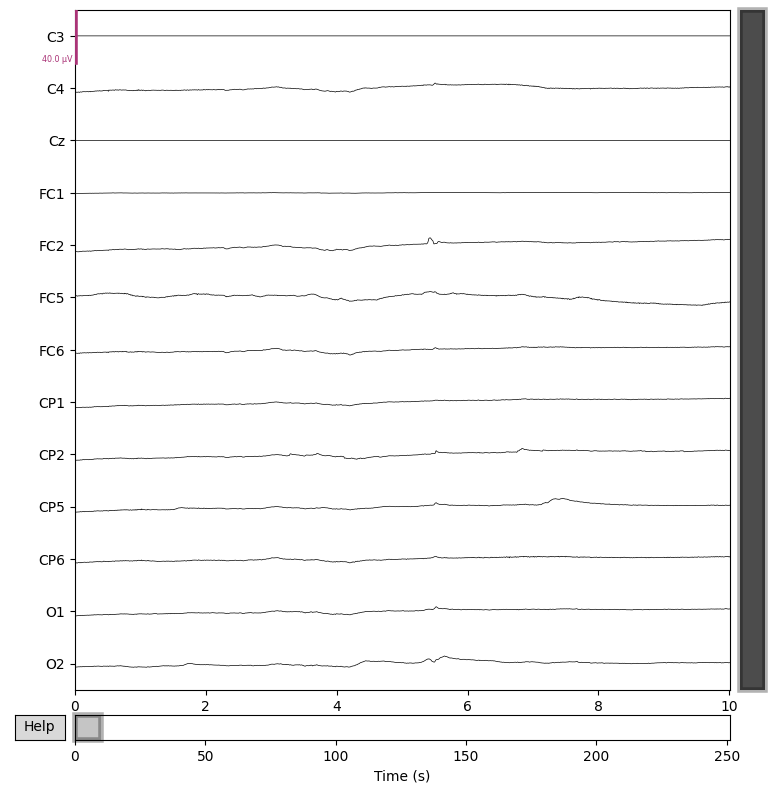

In [21]:
raw = mne.io.RawArray(eeg_data, info)
#raw_filter = raw.filter(l_freq = 0.5, h_freq = 60)
raw.plot()
#raw_filter.plot(scalings=dict(eeg=100e-6), duration=1, start=14)

In [22]:
# lets aling the time of event to the recording onset by seconds
start_time = eeg_stream['time_stamps'][0]
marker_stream['time_stamps'] -= start_time

events_num = len(marker_stream['time_series'])
zeros = np.zeros(len(marker_stream['time_series'])).reshape(events_num,1)
# need to solve the string thing
events = np.concatenate((marker_stream['time_stamps'].reshape(events_num,1),zeros,np.array(marker_stream['time_series']).reshape(events_num,1)),axis = 1)
print (events)

[['6.061276098451344' '0.0' 'Standard Trial']
 ['8.06757433214807' '0.0' 'Standard Trial']
 ['10.073315665824339' '0.0' 'Standard Trial']
 ['12.076322799490299' '0.0' 'Standard Trial']
 ['14.078997133125085' '0.0' 'Standard Trial']
 ['16.08192346675787' '0.0' 'Standard Trial']
 ['18.089166500460124' '0.0' 'Standard Trial']
 ['20.091997234121663' '0.0' 'Standard Trial']
 ['22.096726267773192' '0.0' 'Standard Trial']
 ['24.103975001489744' '0.0' 'Standard Trial']
 ['26.10789153512451' '0.0' 'Standard Trial']
 ['28.115785868867533' '0.0' 'Standard Trial']
 ['30.12277200256358' '0.0' 'Standard Trial']
 ['32.12638773620711' '0.0' 'Standard Trial']
 ['34.12823576986557' '0.0' 'Target Trial']
 ['36.13378750352422' '0.0' 'Target Trial']
 ['38.13805333717028' '0.0' 'Standard Trial']
 ['40.14323087086086' '0.0' 'Standard Trial']
 ['42.14774120450602' '0.0' 'Standard Trial']
 ['44.15478613821324' '0.0' 'Standard Trial']
 ['46.15900217188755' '0.0' 'Target Trial']
 ['48.16493960560183' '0.0' 'Stan

In [23]:
# make sure no strings in marker
events[:,2] = np.char.replace(events[:,2], 'Standard Trial', '20')
events[:,2] = np.char.replace(events[:,2], 'Target Trial', '21')
# delete last row as it contains empty string
events = np.delete(events, -1, 0)

In [24]:
events = events.astype(float)
events[:,0] *= 125 # time to time stamp

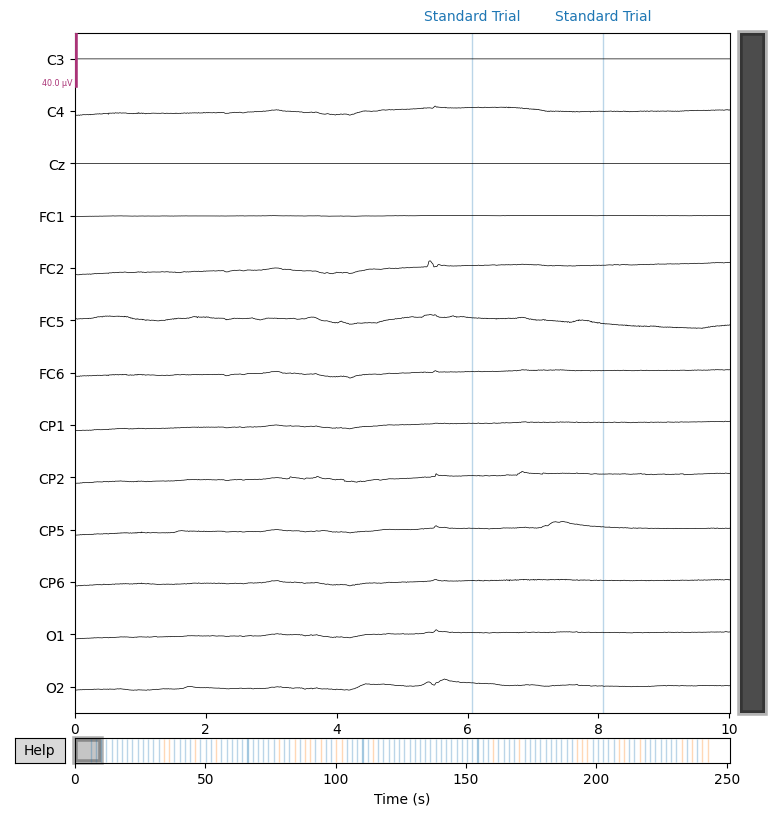

In [25]:
mapping = {20: 'Standard Trial', 21: 'Target Trial'}
# PAY ATTENTION. sfreq=raw.info['sfreq'] is not good. since raw.info['sfreq'] is 250 and not 125
annot_from_events = mne.annotations_from_events(
    events=events, event_desc=mapping, sfreq=125,
    orig_time=None)
raw.set_annotations(annot_from_events)
raw.plot()

# Preproccesing

### Mark bad channels and drop them

In [26]:
raw.filter(h_freq=60 ,l_freq = 0.5)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 61.25 Hz)
- Filter length: 825 samples (6.600 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished


<RawArray | 13 x 31405 (251.2 s), ~3.1 MB, data loaded>

In [27]:
raw.info['bads'] = ['C3', 'Cz', 'FC5', 'FC1']
raw.info['bads']

['C3', 'Cz', 'FC5', 'FC1']

In [28]:
raw.drop_channels(raw.info['bads'])

<RawArray | 9 x 31405 (251.2 s), ~2.2 MB, data loaded>

## Epoching

In [29]:
events_from_annot, event_dict = mne.events_from_annotations(raw)
epochs = mne.Epochs(raw, events_from_annot, preload = True, tmin=-0.2, tmax=1, event_id=event_dict,detrend=0,baseline= (-0.2,0))

Used Annotations descriptions: ['Standard Trial', 'Target Trial']
Not setting metadata
119 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 119 events and 151 original time points ...
0 bad epochs dropped


## Plot evoked data

No projector specified for this dataset. Please consider the method self.add_proj.


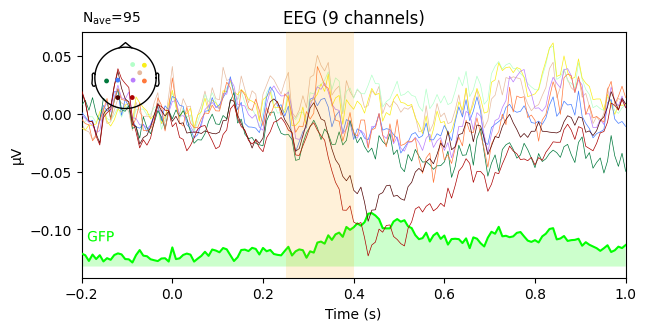

In [30]:
P300_window = [0.25,0.4]
par_picks = ['FC21','FC','C4', 'CP2', 'CP1'] # to plot only parietal

odd_evoked =  epochs['Target Trial'].average()
odd_evoked.plot(gfp=True,
    highlight=P300_window)

odd_evoked.plot_joint(picks='eeg',times=[0,0.2,0.3,0.4])


stand_evoked =  epochs['Standard Trial'].average()
stand_evoked.plot(gfp=True,
    highlight=P300_window)

In [31]:
epochs

Number of events,119
Events,Standard Trial: 95Target Trial: 24
Time range,-0.200 – 1.000 sec
Baseline,-0.200 – 0.000 sec


In [32]:
clfs = OrderedDict()
clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['Xdawn + RegLDA'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))

clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())


clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(), MDM())

# format data
picks_eeg = epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

# define cross validation
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', cv=cv, n_jobs=-1)
    auc.extend(res)
    methods.extend([m]*len(res))

results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.2, 0.85)
sns.despine()

AttributeError: 'DataFrame' object has no attribute 'sns'

In [19]:
events_from_annot, event_dict = mne.events_from_annotations(raw)
epochs = mne.Epochs (raw,events=events_from_annot, event_id=[event_dict['Standard Trial'], event_dict['Target Trial']], tmin=-0.2, tmax=2,detrend=0,baseline = (-0.2, 0))

Used Annotations descriptions: ['Standard Trial', 'Target Trial']
Not setting metadata
119 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


SyntaxError: iterable argument unpacking follows keyword argument unpacking (208308581.py, line 1)

In [ ]:
tmin=1.
tmax=6.
fmin = 1.
fmax = 60.
spectrum = epochs.compute_psd(
    'welch',
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0, n_per_seg=None,
    tmin=tmin, tmax=tmax,
    fmin=fmin, fmax=fmax,
    window='boxcar',
    verbose=False)
psds, freqs = spectrum.get_data(return_freqs=True)

In [47]:
def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate((
        np.ones(noise_n_neighbor_freqs),
        np.zeros(2 * noise_skip_neighbor_freqs + 1),
        np.ones(noise_n_neighbor_freqs)))
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode='valid'),
        axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(
        mean_noise, pad_width=pad_width, constant_values=np.nan
    )

    return psd / mean_noise

In [48]:
snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3,
                    noise_skip_neighbor_freqs=1)

In [49]:
fig, axes = plt.subplots(2, 1, sharex='all', sharey='none', figsize=(8, 5))
freq_range = range(np.where(np.floor(freqs) == 1.)[0][0],
                   np.where(np.ceil(freqs) == fmax - 1)[0][0])

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0, 1))[freq_range]
psds_std = psds_plot.std(axis=(0, 1))[freq_range]
axes[0].plot(freqs[freq_range], psds_mean, color='b')
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std,
    color='b', alpha=.2)
axes[0].set(title="PSD spectrum", ylabel='Power Spectral Density [dB]')

# SNR spectrum
snr_mean = snrs.mean(axis=(0, 1))[freq_range]
snr_std = snrs.std(axis=(0, 1))[freq_range]

axes[1].plot(freqs[freq_range], snr_mean, color='r')
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std,
    color='r', alpha=.2)
axes[1].set(
    title="SNR spectrum", xlabel='Frequency [Hz]',
    ylabel='SNR', ylim=[-2, 30], xlim=[fmin, fmax])
fig.show()